<a href="https://www.kaggle.com/code/tommasofacchin/text-summarization-transformers-from-scratch?scriptVersionId=288220616" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Seq2Seq and Encoder-Decoder

## What is a Seq2Seq Model
A sequence-to-sequence (Seq2Seq) model is designed to take an input sequence and produce an output sequence. It’s widely used in tasks like machine translation, text summarization, and chatbots.

**Example:**  
Input: "Hello, how are you?"  
Output: "Ciao, come stai?"

---

## Encoder-Decoder Architecture (Expanded)

A typical Seq2Seq model has two main parts: the **encoder** and the **decoder**. The design allows the model to process sequences of variable length.  

### Encoder
The encoder reads the input sequence and compresses it into a set of hidden states or a context vector. This vector captures the important information from the input and has a fixed size, though it does not need to match the decoder's size. The hidden states can either be passed as a whole to the decoder or connected at every decoding step.  

At each step, the encoder updates its hidden state based on the previous hidden state and the current input. In mathematical terms, for a simple RNN:

$$
H_t^{encoder} = \phi(W_{HH} \cdot H_{t-1}^{encoder} + W_{HX} \cdot X_t)
$$

Where:  
- $H_t^{encoder}$ = hidden state at time $t$ in the encoder  
- $X_t$ = input at time $t$  
- $W_{HH}$ = weight matrix connecting hidden states  
- $W_{HX}$ = weight matrix connecting input to hidden states  
- $\phi$ = activation function (e.g., tanh or ReLU)

---

### Decoder
The decoder generates the output sequence one token at a time. Its initial hidden state is set to the final hidden state of the encoder. For a simple RNN decoder:

$$
H_t^{decoder} = \phi(W_{HH} \cdot H_{t-1}^{decoder} + W_{HY} \cdot Y_{t-1})
$$

The output at each step is computed as:

$$
Y_t = W_{HY} \cdot H_t^{decoder}
$$

Where:  
- $H_t^{decoder}$ = hidden state at time $t$ in the decoder  
- $Y_t$ = output at time $t$  
- $W_{HY}$ = weight matrix connecting decoder hidden state to output  

### Implementation Notes
- Encoders and decoders are typically implemented with **RNNs, LSTMs, or GRUs**.  
- The input and output vectors are of fixed size, but the encoder and decoder can have different hidden dimensions.  
- During training, **teacher forcing** is often used, providing the correct previous token to the decoder instead of its own prediction.  

---

## Tokenization

Before feeding text into a Seq2Seq or Transformer model, the raw text must be converted into numerical form.  
This is done through **tokenization**, which splits text into smaller units (tokens) such as words or subwords.  

Each token is then mapped to a unique integer using a **vocabulary** built from the dataset.  
The model processes these integers rather than the raw text.

**Example:**

Input text: `"Transformers improve summarization."`  
Tokens: `["transformers", "improve", "summarization", "."]`  
Token IDs: `[201, 57, 1342, 4]`

### Why Tokenization Matters
- Converts variable-length text into consistent, model-readable sequences.  
- Helps capture word frequency and context relationships.  
- Reduces vocabulary size when using subword tokenization (e.g., Byte Pair Encoding).  

In this project, tokenization is part of preprocessing and includes:
- **Lowercasing** the text  
- **Removing special characters and URLs**  
- **Splitting into tokens by spaces**  
- Adding **start (`sostok`)** and **end (`eostok`)** tokens to mark summary boundaries  

After tokenization, sequences will later be converted to integer IDs, padded or truncated to a fixed length

---

# Transformers
Transformers can be seen as an evolution of Seq2Seq models. Instead of processing sequences step by step like LSTMs or GRUs, they rely entirely on **attention mechanisms** to process all tokens in parallel and capture relationships between them.

### Attention in Transformers
Attention is the core mechanism that allows Transformers to focus on relevant parts of the input sequence when producing a representation for each token. It works by comparing each token to all others and weighting them according to importance.

#### How Attention Works
Each token in the sequence is represented by three vectors:
- **Query (Q):** what this token is looking for  
- **Key (K):** what information this token contains  
- **Value (V):** the actual information of the token  

The attention score between two tokens is computed as the similarity between the Query of one token and the Key of another. This determines how much attention one token should pay to another. Mathematically, the attention weights are computed using a scaled dot-product:

$$
\text{Attention}(Q, K, V) = \text{softmax}\Big(\frac{QK^T}{\sqrt{d_k}}\Big) V
$$

Where $d_k$ is the dimensionality of the Key vectors.

- The **softmax** ensures that the weights sum to 1.  
- Each token’s output is a weighted sum of all Value vectors, allowing it to incorporate context from the entire sequence.

#### Multi-Head Attention
Instead of computing attention just once, Transformers use **multiple attention heads** in parallel. Each head can learn to focus on different types of relationships, such as:
- Syntactic relationships (e.g., subject-verb connections)  
- Semantic relationships (e.g., synonyms or related concepts)  

The outputs of all heads are concatenated and projected to form the final representation for each token.

#### Intuition
Imagine reading a sentence and highlighting all the words that are important for understanding each token. Each word “attends” to other words in the sentence that matter most for its meaning. Multi-head attention lets the model do this from multiple perspectives simultaneously.

### Key Components of Transformers
- **Encoder-Decoder Structure:** Like Seq2Seq models, Transformers have an encoder that processes the input and a decoder that generates the output. Both use layers of self-attention and feed-forward networks.  
- **Positional Encoding:** Since Transformers don’t process tokens sequentially, they add positional information so the model knows the order of tokens.  
- **Feed-Forward Layers:** After attention, each token passes through fully connected layers for additional transformation.

### Advantages over LSTM/GRU Seq2Seq
- Processes sequences **in parallel**, speeding up training.  
- Handles **long sequences** more effectively with attention.  
- Captures **complex relationships** between tokens regardless of distance.  
- Scales easily to **very deep models** and large datasets.

### Use Cases
Transformers are the backbone of many state-of-the-art models for tasks such as:
- Machine translation (e.g., T5, MarianMT)  
- Text summarization (e.g., BART, Pegasus)  
- Question answering and chatbots (e.g., GPT, BERT-based models)

In [1]:
%pip install sentencepiece
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Data Preparation

Prepare and clean the dataset for the summarization model:

- **Load datasets:** Read two CSV files containing news articles and their summaries.
- **Combine datasets:** Merge datasets while selecting relevant `text` and `summary` columns.
- **Text cleaning:**  
  - Convert text to lowercase.  
  - Remove special characters.  
  - Replace URLs with domain names.  
  - Reduce multiple spaces.
- **Tokenization:** Split cleaned text into tokens (words) and add `_START_` and `_END_` tokens for summaries.
- **Handle missing values:** Drop rows with missing `text` values.
- **Analyze sequence lengths:** Calculate word counts for texts and summaries.
- **Limit sequence lengths:** Restrict `text` to 100 words and `summary` to 15 words.
- **Add model tokens:** Prepend `sostok` and append `eostok` to all summaries to mark start and end for the model.


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

pd.set_option('display.max_colwidth', None)
data = pd.read_excel("/kaggle/input/inshorts-news-data/Inshorts Cleaned Data.xlsx")

print(data.shape)

2025-12-24 13:52:10.221086: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766584330.398761      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766584330.451488      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(55104, 5)


In [3]:
data.head(5)

,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank of ₹209 crore,"The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.",The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme Court will go paperless in six to seven months in a bid to save funds and make the judiciary eco-friendly. He further said the apex court will collect all the records electronically from the lower courts and the high courts so that there is no need to file hard copies.,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylhet, Bangladesh","At least three people were killed, including a policeman, while 30 others were wounded on Saturday evening in two explosions in Sylhet, Bangladesh. The explosions were targetted at people and police officials who were witnessing an over 30-hour-long gunfight between extremists and commandos. Earlier on Friday, a man had blown himself up in front of a checkpoint near Dhaka Airport.",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in futures?,"Mukesh Ambani-led Reliance Industries (RIL) was barred from trading in futures market for a year over stake sale in Reliance Petroleum (RPL). In 2007, RIL sold 4.1% stake in RPL, but shares were first &#39;short-sold&#39; in futures market to avoid a fall in RPL stocks. Short sale means selling shares with plans to buy them back later at lower prices.",Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Times Now: Arnab,"TV news anchor Arnab Goswami has said he was told he could not do the programme two days before leaving Times Now. &#34;18th November was my last day, I was not allowed to enter my own studio,&#34; Goswami added. &#34;When you build an institution and are not allowed to enter your own studio, you feel sad,&#34; the journalist further said.",YouTube,23:24:00,2017-03-25


In [4]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = text.replace("39", "'")
    text = text.replace("34", '"')
    text = text.replace("’", "'")
    text = re.sub(r"[^a-z0-9 ,.'\-?()\"]", " ", text)
    text = re.sub(r"\s*'\s*", "'", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    return f"<sos> {text} <eos>"


In [5]:
df = pd.DataFrame()

df['text'] = data['Short'].apply(clean_text)
df['summary'] = data['Headline'].apply(clean_text)

MAX_TEXT_LEN = 100
MAX_SUMMARY_LEN = 20
SAMPLE_SIZE = len(df)

df = df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)

print(df.shape)
df.head(2)

(55104, 2)


,text,summary
0,"<sos> gangster-turned-politician mukhtar ansari has won from the mau constituency in uttar pradesh after polling 96,793 votes, defeating the nearest candidate by over 8,000 votes. ansari, who was the sitting mla from the constituency, had allied with the mayawati-led bahujan samaj party before the elections. ansari has been accused of murdering a bjp mla. <eos>",<sos> gangster-turned-politician mukhtar ansari wins by 8000 votes <eos>
1,"<sos> indira gandhi has been the only woman till date to have presented the union budget of india in 1970-71. this came after indira gandhi, the then prime minister, took over the finance portfolio after morarji desai resigned as the minister of finance. so far, she has been the only woman finance minister of india. <eos>",<sos> indira gandhi only woman to have presented the budget <eos>


# Transformer Model with Self-Attention

Similar to the Seq2Seq architecture, the Transformer follows an **encoder–decoder structure**, but instead of recurrent layers it relies entirely on **Multi-Head Self-Attention**.  
This allows the model to process all tokens **in parallel** and learn relationships between words regardless of their distance in the sequence.

During training, the model takes **two inputs**:  
1. The encoder input (`text`) – the tokenized article.  
2. The decoder input (`summary`) – the summary shifted by one token.  

The **target output** is the summary shifted forward by one position. The decoder learns to predict each word based on the previously generated ones and the encoded representation of the full text.

---

**Encoder**  
- The input article sequence (`MAX_TEXT_LEN`) is first transformed using an **Embedding layer**.  
- A **Positional Encoding** is added to preserve the order of words (since attention has no notion of sequence order by itself).  
- The embedded input is processed by one or more **Multi-Head Self-Attention** blocks:
  - Each word attends to **all other words** in the input
  - Relationships between distant tokens are captured more effectively than in RNNs  
- A **Feed-Forward Network** (FFN) refines the contextual representations.
- **Residual connections** and **Layer Normalization** improve gradient flow and training stability.

---

**Decoder**  
- Similar positional embeddings are applied to the shifted summary tokens.  
- The decoder uses two attention mechanisms:
  1. **Masked Self-Attention**: ensures the model cannot “peek” at future words when predicting the next token.
  2. **Encoder-Decoder Attention**: allows the decoder to focus on relevant parts of the input article.
- A **Feed-Forward Network** further processes the attended features.
- A final **Dense layer with Softmax** outputs a probability distribution over all words in the vocabulary at each time step.

---

**sostok and eostok**  
In sequence-to-sequence tasks such as abstractive text summarization, **special tokens** are essential for controlling how a model generates text:

- `<sostok>` → marks the **start** of the output sequence  
- `<eostok>` → marks the **end** of the sequence  

However, these tokens **do not** play the same role during training across different architectures.

Transformers use **masked self-attention** in the decoder, meaning that at time *t* the model can only attend to **previous tokens**.
Therefore:

- `<sostok>` must be present **only in the decoder input**  
- `<sostok>` must be removed from the decoder target  

Predicting a start token would make no sense and causes failure modes such as:

- the model repeatedly outputting `<sostok>`
- inability to begin sequences with meaningful content

The EOS token **must remain in the targets**, because:

- it teaches the model **when to stop writing**
- without it, generation may become too long or infinite

LSTM encoder-decoder models:

- receive the final hidden state as initial context
- do **not** use masked attention
- often ignore the first timestep in loss computation

So `<sostok>` in targets is less harmful there.

---

Thanks to the Self-Attention mechanism, Transformers **capture global context efficiently** and typically produce **more coherent and fluent summaries**, especially for longer texts.

### Preparing Transformer Inputs

To train the Transformer in an encoder–decoder setup, we need to properly structure the input data:

- The **encoder input** is the full tokenized article (`x_train`)
- The **decoder input** is the summary sequence **shifted right**, starting with `<sostok>`
- The **decoder target** is the same summary **shifted left**, ending with `<eostok>`

This shifting ensures that at each timestep the decoder learns to predict the **next** word using:
1. The previously processed summary tokens  
2. Attention over the encoder output  

In text summarization, token-level accuracy can be misleading because it only measures whether each predicted token matches the ground truth at the same position. It does not capture semantic meaning, fluency, word order, or relevance, and it can be inflated by common tokens like padding or start/end markers. A model can have high accuracy while producing poor summaries. Better evaluation uses metrics like ROUGE-1, ROUGE-2, and ROUGE-L, which measure overlap of unigrams, bigrams, and longest common subsequences between generated and reference summaries. During training, it is better to monitor validation loss and evaluate summaries qualitatively or with ROUGE rather than relying on token accuracy.

## Predict

Note importanti:

Look-ahead mask a inference non serve se generi un token alla volta (greedy decoding step-by-step).

Padding mask dell’encoder serve al decoder per ignorare i pad token dell’input.

Quando fai l’inference dovrai generare token uno per uno, aggiornando dec_input_inf ad ogni step.

Generated summary: ripete continuamente parole (cannot cannot cannot, power power power…) → questo è un loop di ripetizione, tipico dei modelli seq2seq che non hanno abbastanza regolarizzazione sulla generazione.

Generated beam search summary: testo quasi completamente fuori tema → indica che il modello non ha appreso bene il contenuto semantico e il beam search amplifica le frasi che appaiono più “probabili” a livello di token, ma non corrette.


Limiting the vocabulary in a Transformer is important because it reduces the size of the embedding matrices and the final softmax layer, making the model faster and lighter. It also helps prevent overfitting by removing extremely rare words that add noise rather than useful information. A smaller vocabulary uses less memory and often leads to more stable training, which can be important when working with limited hardware. However, reducing the vocabulary also means losing information, because words outside the limit are replaced with an unknown token. This can harm tasks like summarization, where specific terms, names, or technical words matter. A limited vocabulary also restricts what the model can generate, since it can only output words it knows.

I tried limiting the vocabulary, but it ended up harming the model’s performance.

We wanted to continue training a Transformer model after the first epoch without losing the optimizer state. The issue was that creating a new optimizer reset the step count, making the learning rate extremely small due to the warmup schedule. To fix this, we restored a full checkpoint including both the model and optimizer. This ensures the weights, optimizer moments, and step count are preserved, so the learning rate continues correctly. Training can now continue from where it left off, and checkpoints can be saved after each epoch to resume seamlessly in future sessions.

Using a single tokenizer for both input text and summaries is a design choice with clear advantages and trade-offs. The main benefit is consistency: the encoder and decoder operate on the same vocabulary and token representations, which makes cross-attention easier to learn and stabilizes training. The model does not need to internally translate between two different symbolic systems, so convergence is faster and behavior is more predictable. A shared tokenizer also reduces the total number of parameters, avoids duplicated tokens, and improves generalization, especially for named entities, numbers, and rare words that appear in both input and output. Debugging is simpler because there is only one source of truth for tokenization.

The main drawback is that a single tokenizer is a compromise between two different distributions. Input texts are long and diverse, while summaries are short and dense. A shared vocabulary may allocate capacity to tokens that are useful for the input but rarely needed in the output, slightly reducing efficiency. It also offers less control over the style and structure of the generated summaries compared to using a specialized tokenizer for the output. In addition, special tokens such as start and end markers must be handled carefully to avoid interfering with the encoder input.

In practice, a single tokenizer is usually the better choice for summarization, translation, and other sequence-to-sequence tasks, especially with small or medium datasets and custom or experimental tokenizers. Separate tokenizers can make sense for very large datasets or highly specialized outputs, but they increase complexity and instability. For most practical cases, a shared tokenizer provides better stability, faster learning, and fewer hidden failure modes.

When resuming training from a checkpoint, the Transformer seems to start from zero only because the first batches always show very low accuracy. This is normal and not a sign of lost weights. The decoder struggles with the first tokens due to masking, so accuracy is naturally low at the start of each epoch. If the dataset uses a fixed shuffle and the same examples appear first every time, you will always see the same low accuracy at the beginning. The proof that the checkpoint is restored correctly is that the accuracy rises quickly after a few hundred batches, which would not happen if the model had really restarted from scratch.

In [6]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'

# Tokenizer
article_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)

# article_tokenizer.fit_on_texts(df['text'])
# summary_tokenizer.fit_on_texts(df['summary'])

# Fit
article_texts = df["text"].astype(str).tolist()
summary_texts = df["summary"].astype(str).tolist()

article_tokenizer.fit_on_texts(article_texts)
summary_tokenizer.fit_on_texts(summary_texts)

# Vocabularies
x_voc_size = len(article_tokenizer.word_index) + 1
y_voc_size = len(summary_tokenizer.word_index) + 1
print(f"Encoder vocab: {x_voc_size} \n Decoder vocab: {y_voc_size}")

Encoder vocab: 95768 
 Decoder vocab: 38125


In [7]:
# Sequences
inputs = article_tokenizer.texts_to_sequences(article_texts)
targets = summary_tokenizer.texts_to_sequences(summary_texts)

# padding
inputs = pad_sequences(inputs, maxlen=MAX_TEXT_LEN, padding='post', truncating='post')
targets = pad_sequences(targets, maxlen=MAX_SUMMARY_LEN, padding='post', truncating='post')

inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

I0000 00:00:1766584354.921976      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
batch_size = 64
dataset = (tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(1000, seed=42, reshuffle_each_iteration=False).batch(batch_size))


def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2



class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2



class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training=False, mask=None):
        seq_len = tf.shape(x)[1]
    
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)
    
        return x
    
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
    
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]  

    
        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](
                x, 
                enc_output, 
                training=training, 
                look_ahead_mask=look_ahead_mask, 
                padding_mask=padding_mask
            )
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
    
        return x, attention_weights




class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training=False, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
        enc_output = self.encoder(x=inp, training=training, mask=enc_padding_mask)
        dec_output, attention_weights = self.decoder(x=tar, enc_output=enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attention_weights

In [9]:
def smooth_labels(labels, vocab_size, smoothing=0.05):
    confidence = 1.0 - smoothing
    low_conf = smoothing / tf.cast(vocab_size - 1, tf.float32)
    labels_one_hot = tf.one_hot(labels, depth=vocab_size)
    return labels_one_hot * confidence + low_conf

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000, factor=1.0):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
        self.factor = factor
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32) 
        step = tf.maximum(step, 1.0)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2) * self.factor

In [10]:
num_layers = 3   
d_model = 128        
dff = 512            
num_heads = 4        
dropout_rate = 0.1  

d_model = 256 
dropout_rate = 0.2

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=x_voc_size,
    target_vocab_size=y_voc_size,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate
)

dummy_input = tf.constant([[1]*MAX_TEXT_LEN], dtype=tf.int64)
dummy_target = tf.constant([[1]*MAX_SUMMARY_LEN], dtype=tf.int64)
_ = transformer(dummy_input, dummy_target, training=False)
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │    26,097,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Decoder)               │ ?                      │    12,132,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (1, 20, 38125)         │     9,798,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,028,397 (183.21 MB)

 Trainable params: 48,028,397 (183.21 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
learning_rate = CustomSchedule(d_model, warmup_steps=4000, factor=1.0)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)


tf.print("Learning rate:", optimizer.learning_rate)
print("Optimizer step:", optimizer.iterations.numpy())

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

Learning rate: 2.47052952e-07
Optimizer step: 0


In [12]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp,
            tar_inp,
            training=True,
            enc_padding_mask=enc_padding_mask,
            look_ahead_mask=combined_mask,
            dec_padding_mask=dec_padding_mask,
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))


Epoch 001 | Train Loss 8.3865 | Accuracy 0.1138 | Time 173.45s | LR 0.000213
Epoch 002 | Train Loss 6.9334 | Accuracy 0.1544 | Time 149.29s | LR 0.000425
Epoch 003 | Train Loss 6.1661 | Accuracy 0.1918 | Time 149.31s | LR 0.000638
Epoch 004 | Train Loss 5.5708 | Accuracy 0.2328 | Time 149.30s | LR 0.000851
Epoch 005 | Train Loss 5.1269 | Accuracy 0.2680 | Time 149.31s | LR 0.000953
Epoch 006 | Train Loss 4.7331 | Accuracy 0.3034 | Time 149.31s | LR 0.000870
Epoch 007 | Train Loss 4.3954 | Accuracy 0.3368 | Time 149.35s | LR 0.000805
Epoch 008 | Train Loss 4.1236 | Accuracy 0.3670 | Time 149.37s | LR 0.000753
Epoch 009 | Train Loss 3.8900 | Accuracy 0.3938 | Time 149.36s | LR 0.000710
Epoch 010 | Train Loss 3.6882 | Accuracy 0.4189 | Time 149.37s | LR 0.000674
Epoch 011 | Train Loss 3.5050 | Accuracy 0.4412 | Time 149.37s | LR 0.000642
Epoch 012 | Train Loss 3.3355 | Accuracy 0.4628 | Time 149.34s | LR 0.000615
Epoch 013 | Train Loss 3.1786 | Accuracy 0.4830 | Time 149.34s | LR 0.000591

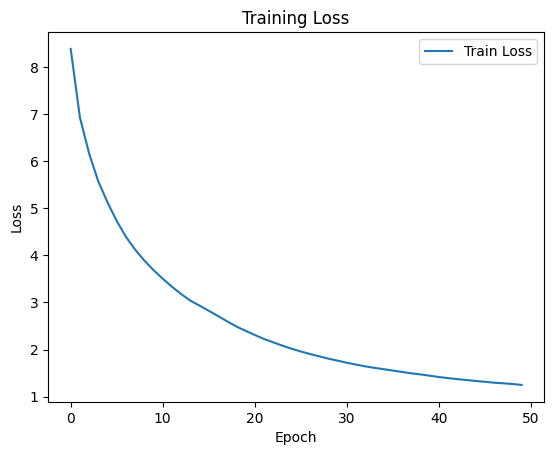

In [13]:
patience = 5
best_loss = float('inf')
wait = 0
epochs = 50

train_losses = []

for epoch in range(epochs):
    start_epoch = time.time()
    train_loss.reset_state()
    train_accuracy.reset_state()

    # Training
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)

    current_train_loss = train_loss.result()
    train_losses.append(current_train_loss.numpy())

    
    # Early stopping
    if current_train_loss < best_loss:
        best_loss = current_train_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    
    current_lr = learning_rate(optimizer.iterations).numpy()
    print(f'Epoch {epoch+1:03d} | Train Loss {current_train_loss:.4f} | '
          f'Accuracy {train_accuracy.result():.4f} | '
          f'Time {time.time() - start_epoch:.2f}s | LR {current_lr:.6f}')



plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [14]:
def summarize(input_article, beam_width=3):
    input_ids = article_tokenizer.texts_to_sequences([input_article])
    input_ids = tf.keras.preprocessing.sequence.pad_sequences(
        input_ids, maxlen=MAX_TEXT_LEN, padding='post', truncating='post'
    )
    
    encoder_input = tf.cast(input_ids, tf.int32)

    sos_id = summary_tokenizer.word_index['<sos>']
    eos_id = summary_tokenizer.word_index['<eos>']

    sequences = [([sos_id], 0.0)]
    completed_sequences = []

    for _ in range(MAX_SUMMARY_LEN):
        all_candidates = []
        for seq, score in sequences:
            if seq[-1] == eos_id:
                completed_sequences.append((seq, score))
                continue

            output = tf.expand_dims(seq, 0)
            enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

            predictions, _ = transformer(
                encoder_input,
                output,
                training=False,
                enc_padding_mask=enc_padding_mask,
                look_ahead_mask=combined_mask,
                dec_padding_mask=dec_padding_mask
            )

            logits = predictions[:, -1, :]
            log_probs = tf.nn.log_softmax(logits)

            for t in set(seq):
                if t not in (sos_id, eos_id):
                    log_probs = tf.tensor_scatter_nd_sub(
                        log_probs,
                        [[0, t]],
                        [0.8]
                    )

            top_k = tf.math.top_k(log_probs, k=beam_width)

            for i in range(beam_width):
                token = int(top_k.indices[0, i])
                candidate_score = score + float(top_k.values[0, i])
                candidate_seq = seq + [token]

                length_penalty = ((5 + len(candidate_seq)) / 6) ** 1.1
                normalized_score = candidate_score / length_penalty

                all_candidates.append((candidate_seq, normalized_score))

        sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_width]
        if not sequences:
            break

    completed_sequences.extend(sequences)

    best_seq = max(completed_sequences, key=lambda tup: tup[1])[0]

    decoded = np.expand_dims([t for t in best_seq if t != sos_id and t != eos_id], 0)
    decoded_text = summary_tokenizer.sequences_to_texts(decoded)[0]

    return decoded_text.strip()

In [15]:
def replace_tokens(s):
    return s.replace("<SOS>", "").replace("<EOS>", "").strip()

for i in range(10):
    text = replace_tokens(df['text'][i])
    real_summary = replace_tokens(df['summary'][i])
    pred_summary = summarize(text)

    print(f"\nText: {text}"
          f"\nReal summary: {real_summary}"
          f"\nPred summary: {pred_summary}")


Text: <sos> gangster-turned-politician mukhtar ansari has won from the mau constituency in uttar pradesh after polling 96,793 votes, defeating the nearest candidate by over 8,000 votes. ansari, who was the sitting mla from the constituency, had allied with the mayawati-led bahujan samaj party before the elections. ansari has been accused of murdering a bjp mla. <eos>
Real summary: <sos> gangster-turned-politician mukhtar ansari wins by 8000 votes <eos>
Pred summary: gangster turned politician mukhtar ansari wins by 96 000 votes

Text: <sos> indira gandhi has been the only woman till date to have presented the union budget of india in 1970-71. this came after indira gandhi, the then prime minister, took over the finance portfolio after morarji desai resigned as the minister of finance. so far, she has been the only woman finance minister of india. <eos>
Real summary: <sos> indira gandhi only woman to have presented the budget <eos>
Pred summary: indira gandhi only woman to have present

In [16]:
texts = [
    "Apple Inc. announced a new campus in Austin, Texas, expected to create over 5,000 jobs by 2026, focusing on hardware R&D. CEO Tim Cook emphasized innovation and community commitment.",
    
    "The Prime Minister held a press conference on Tuesday, unveiling new economic reforms aimed at boosting small businesses and creating job opportunities across the country.",

    "In yesterday’s football match, Barcelona defeated Real Madrid 3-1, with Messi scoring a hat-trick. The victory gives Barcelona an edge in the league standings.",
    
    "A new study revealed that regular exercise and a balanced diet can significantly reduce the risk of heart disease and improve overall life expectancy.",
    
    "The latest Marvel movie broke box office records over the weekend, earning over $200 million globally in its opening weekend.",
    
    "Scientists discovered a new species of dolphin in the Pacific Ocean, highlighting the importance of marine conservation and biodiversity protection.",
    
    "The stock market saw a sharp increase today, with tech stocks leading the gains as investors responded positively to quarterly earnings reports."
]

for text in texts:
    print(f"\nText : {text} \nSummary (transformer) : {summarize(text)}")


Text : Apple Inc. announced a new campus in Austin, Texas, expected to create over 5,000 jobs by 2026, focusing on hardware R&D. CEO Tim Cook emphasized innovation and community commitment. 
Summary (transformer) : apple to create 5 000 jobs globally by mid way

Text : The Prime Minister held a press conference on Tuesday, unveiling new economic reforms aimed at boosting small businesses and creating job opportunities across the country. 
Summary (transformer) : pm modi announces new reforms across india

Text : In yesterday’s football match, Barcelona defeated Real Madrid 3-1, with Messi scoring a hat-trick. The victory gives Barcelona an edge in the league standings. 
Summary (transformer) : barcelona thrash messi 3 1 in their hat trick

Text : A new study revealed that regular exercise and a balanced diet can significantly reduce the risk of heart disease and improve overall life expectancy. 
Summary (transformer) : human exercise can reduce risk to treat life risk study

Text : Th